# Exp7: Sentence Embeddings
This file tests neural networks trained on sentence embeddings to predict the presence of grammatical constructions in them.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
import random
from tqdm import tqdm
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import config

torch.manual_seed(config.SEED)
np.random.seed(config.SEED)
random.seed(config.SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/scratch_local/mpb672-5192672/tmp/ipykernel_42744/1861154141.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/mnt/qb/work/meurers/mpb672/conda_envs/llm2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load dataset

In [2]:
df = pd.read_json('../dat/egp_merged.json')

Load and test embeddings model

In [3]:
# Extracting one construct with its examples
class SentenceDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.sentences[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
    
def get_dataset(row, tokenizer, max_len, random_negatives=True, ratio = 0.5, max_positive_examples=500):
    # assemble dataset for one construction
    # 50% positive examples
    unique_examples = list(set(row['augmented_examples']))
    sentences = unique_examples[:max_positive_examples]
    labels = [1] * len(sentences)

    num_augs = int(len(sentences) * (1-ratio)) if random_negatives else len(sentences)
    # augmented negative examples
    aug_neg_examples = list(set(row['augmented_negative_examples']).difference(set(row['augmented_examples'])))
    random.shuffle(aug_neg_examples)
    unique_negatives = aug_neg_examples[:num_augs]
    sentences += unique_negatives
    labels += [0] * len(unique_negatives)
    
    if random_negatives:
        num_rands = max_positive_examples - len(unique_negatives) # fill to an even number
        # rest: random negative examples (positive from other constructions)
        neg_examples = [example for sublist in df.loc[df['#'] != row['#'], 'augmented_examples'].to_list() for example in sublist]
        random.shuffle(neg_examples)
        sentences += neg_examples[:num_rands]
        labels += [0] * len(neg_examples[:num_rands])
    assert len(sentences) == 2 * max_positive_examples
    assert sum(labels) == max_positive_examples
    return SentenceDataset(sentences, labels, tokenizer, max_len)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=config.CACHE_DIR)
max_len = 128  # Max length for BERT

# Get dataset for a specific row
row = df.iloc[1]
print(row['Can-do statement'])
print(row['Example'])
print("\n")
for element in row['augmented_examples'][:10]:
    print(element)
print("\n")
for element in row['augmented_negative_examples'][:10]:
    print(element)
dataset = get_dataset(row, tokenizer, max_len)

Can use 'but' to join a limited range of common adjectives, after 'be'.
The weather was cloudy but fine. 

It was cheap but beautiful.


The movie was slow but entertaining.
The dress was old but elegant.
The meal was simple but delicious.
The house is small but cozy.
The exercise was tough but rewarding.
The song is sad but beautiful.
The car is old but reliable.
The book is short but informative.
The room is small but tidy.
The girl is shy but friendly.


The movie was slow and entertaining.
The dress was old yet elegant.
The meal was simple and delicious.
The house is small yet cozy.
The exercise was tough yet rewarding.
The song is sad and beautiful.
The car is old yet reliable.
The book is short yet informative.
The room is small yet tidy.
The girl is shy and friendly.


In [4]:
def get_loaders(dataset, batch_size=8):
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader

Let's define our network, based on a BERT backbone with multiple taks heads for each rule.

In [5]:
class NonlinearTaskHead(torch.nn.Module):
    def __init__(self, input_dim, num_labels, hidden_dim=16):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.classifier = torch.nn.Linear(hidden_dim, num_labels)

    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        output = self.classifier(hidden)
        return output

class MultiTaskBERT(torch.nn.Module):
    def __init__(self, bert, task_heads):
        super().__init__()
        self.bert = bert
        self.task_heads = torch.nn.ModuleList(task_heads)

    def forward(self, input_ids, attention_mask, task_id):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        task_output = self.task_heads[task_id](pooled_output)
        return task_output

In [6]:
def validate(model, dataloaders):
    model.eval() 
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_dataloaders = [loader[1] for loader in dataloaders]
    for task_id, val_loader in tqdm(enumerate(val_dataloaders), total=len(val_dataloaders)):
        val_loss = 0
        val_steps = 0
        correct = 0
        total = 0
        all_targets = []
        all_predictions = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
    
                outputs = model(input_ids, attention_mask=attention_mask, task_id=task_id)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_steps += 1
    
                predicted = outputs.argmax(dim=1)  # Assuming a classification task
    
                # Accumulate all targets and predictions
                all_targets.extend(labels.tolist())
                all_predictions.extend(predicted.tolist())
    
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / val_steps
        val_losses.append(avg_val_loss)
        val_accuracies.append(correct / total)
        val_precisions.append(precision_score(all_targets, all_predictions, average='binary'))
        val_recalls.append(recall_score(all_targets, all_predictions, average='binary'))
    return val_losses, val_accuracies, val_precisions, val_recalls

In [7]:
def plot_validation(train_losses, val_losses, val_accuracies, val_precisions, val_recalls):
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.bar(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Task')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.bar(range(len(val_precisions)), val_precisions, label='Validation Precision')
    plt.xlabel('Task')
    plt.ylabel('Precision')
    plt.title('Validation Precision')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.bar(range(len(val_recalls)), val_recalls, label='Validation Recall')
    plt.xlabel('Task')
    plt.ylabel('Recall')
    plt.title('Validation Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
level = "A1"
df_level = df[df['Level'] == level]
num_classifiers = min(len(df_level), 500)
backbone_model = BertModel.from_pretrained('bert-base-uncased', cache_dir="/mnt/qb/work/meurers/mpb672/cache")
task_heads = [NonlinearTaskHead(backbone_model.config.hidden_size, 2) for _ in range(num_classifiers)]
multi_task_model = MultiTaskBERT(backbone_model, task_heads).to(device)
datasets = [get_dataset(df_level.iloc[idx], tokenizer, max_len) for idx in tqdm(range(num_classifiers))]
dataloaders = [get_loaders(dataset) for dataset in datasets]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:43<00:00,  2.50it/s]


In [12]:
total_params = sum(p.numel() for p in multi_task_model.parameters())
trainable_params = sum(p.numel() for p in multi_task_model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 110827082
Trainable Parameters: 110827082


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Training loss: 0.3834251676984131


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


Validation loss: 0.24582290671765805
Mean Accuracy: 0.914


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Training loss: 0.17236347410082817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


Validation loss: 0.17555265132337808
Mean Accuracy: 0.943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.49it/s]


Training loss: 0.13482047930452973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


Validation loss: 0.24040894757583736
Mean Accuracy: 0.923


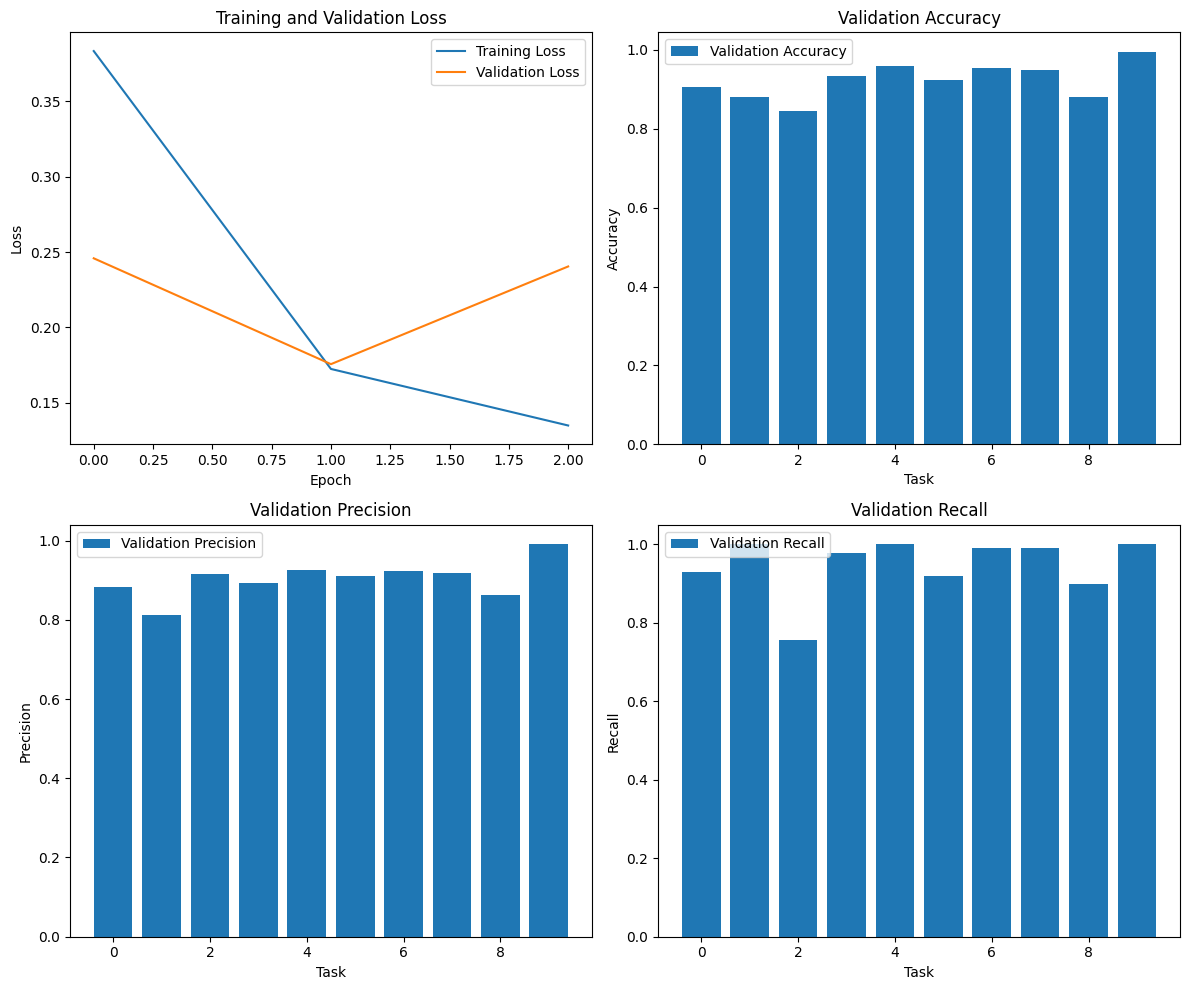

(MultiTaskBERT(
   (bert): BertModel(
     (embeddings): BertEmbeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (token_type_embeddings): Embedding(2, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): BertEncoder(
       (layer): ModuleList(
         (0-11): 12 x BertLayer(
           (attention): BertAttention(
             (self): BertSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): BertSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
               (LayerNorm): LayerNorm((768,), eps=

In [36]:
criterion = torch.nn.CrossEntropyLoss()

def train(model, dataloaders, verbose=True, plots=True, n_epochs_stop = 10, lr=0.0001, num_epochs=5):
    optimizer = torch.optim.AdamW(model.parameters(), lr)
    train_losses = []
    val_losses=[]
    val_accuracies=[]
    val_precisions=[]
    val_recalls=[]
    for epoch in range(num_epochs):  # Number of epochs
        model.train()  # Set the model to training mode
        total_loss = train_steps = 0

        train_loaders = zip(*[loader[0] for loader in dataloaders])
        num_batches = len(dataloaders[0][0])     

        for batches in tqdm(train_loaders, total=num_batches):
            for task_id, batch in enumerate(batches):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
    
                outputs = model(input_ids, attention_mask=attention_mask, task_id=task_id)
                loss = criterion(outputs, labels)
                loss.backward()
                total_loss += loss.item()
                train_steps += 1

            optimizer.step()
            optimizer.zero_grad()
        
        avg_train_loss = total_loss / train_steps
        train_losses.append(avg_train_loss)
        print(f'Training loss: {avg_train_loss}')
        
        batch_val_losses, val_accuracies, val_precisions, val_recalls = validate(model, dataloaders)
        print(f'Validation loss: {np.mean(batch_val_losses)}')
        print(f'Mean Accuracy: {np.mean(val_accuracies)}')
        val_losses.append(np.mean(batch_val_losses))
        if len(val_losses) > 1 and val_losses[-1] > val_losses[-2]:
            break
    if plots:
        plot_validation(train_losses, val_losses, val_accuracies, val_precisions, val_recalls)

    return model, val_accuracies, val_precisions, val_recalls

train(multi_task_model, dataloaders, verbose=False)

In [16]:
def train_level_model(level="A1", max_constructs=500):
    print(f"Level {level}")
    df_level = df[df['Level'] == level]
    num_classifiers = min(len(df_level), max_constructs)
    backbone_model = BertModel.from_pretrained('bert-base-uncased', cache_dir="/mnt/qb/work/meurers/mpb672/cache")
    task_heads = [NonlinearTaskHead(backbone_model.config.hidden_size, 2) for _ in range(num_classifiers)]
    multi_task_model = MultiTaskBERT(backbone_model, task_heads).to(device)
    datasets = [get_dataset(df_level.iloc[idx], tokenizer, max_len) for idx in tqdm(range(num_classifiers))]
    dataloaders = [get_loaders(dataset) for dataset in datasets]
    train(multi_task_model, dataloaders, verbose=False, num_epochs=3)
    torch.save(multi_task_model.state_dict(), '../models/bert/multi_task_model_state_dict_' + level + '.pth')

Level A1


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 50/54 [05:57<00:28,  7.15s/it]


Training loss: 0.6066947817679392


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:33<00:00,  3.27it/s]


Validation loss: 0.48236787065672815
Mean Accuracy: 0.786214238966333


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 50/54 [05:58<00:28,  7.17s/it]


Training loss: 0.37822654245335846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:33<00:00,  3.27it/s]


Validation loss: 0.3337962914459923
Mean Accuracy: 0.8635016087443411


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 50/54 [05:58<00:28,  7.17s/it]


Training loss: 0.2672394463820639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:33<00:00,  3.27it/s]


Validation loss: 0.2786719114619651
Mean Accuracy: 0.885157807282233


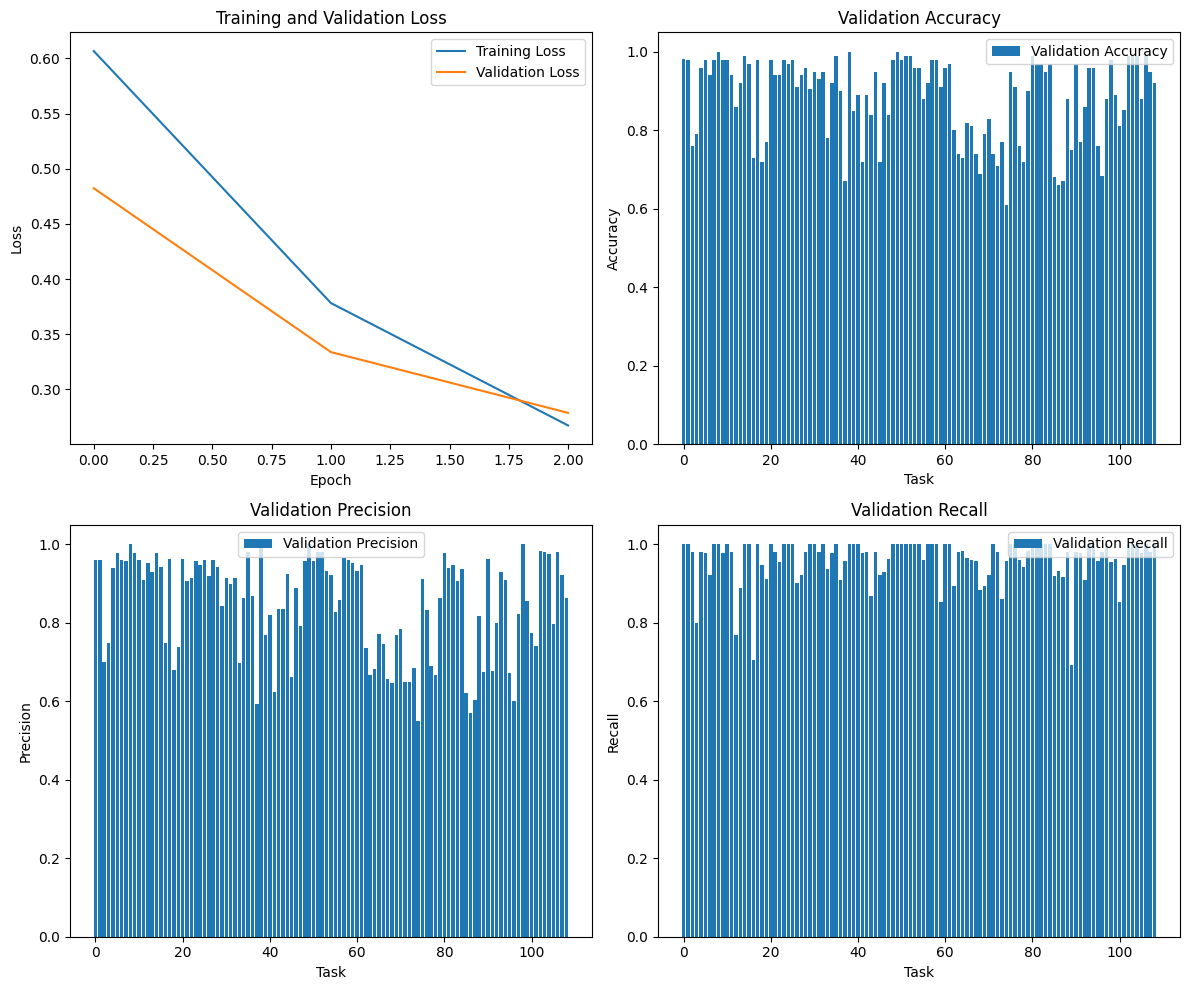

Level A2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [16:00<00:00, 19.20s/it]


Training loss: 0.6166274876785033


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [01:29<00:00,  3.25it/s]


Validation loss: 0.4819796900055485
Mean Accuracy: 0.7914157327145634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [16:00<00:00, 19.21s/it]


Training loss: 0.38298432627660817


 73%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 213/291 [01:05<00:24,  3.25it/s]/mnt/qb/work/meurers/mpb672/conda_envs/llm2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [01:29<00:00,  3.26it/s]


Validation loss: 0.3139048773253897
Mean Accuracy: 0.8739686301692129


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [16:00<00:00, 19.21s/it]


Training loss: 0.265830509273745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [01:29<00:00,  3.26it/s]


Validation loss: 0.25202776483176703
Mean Accuracy: 0.9029493000793503


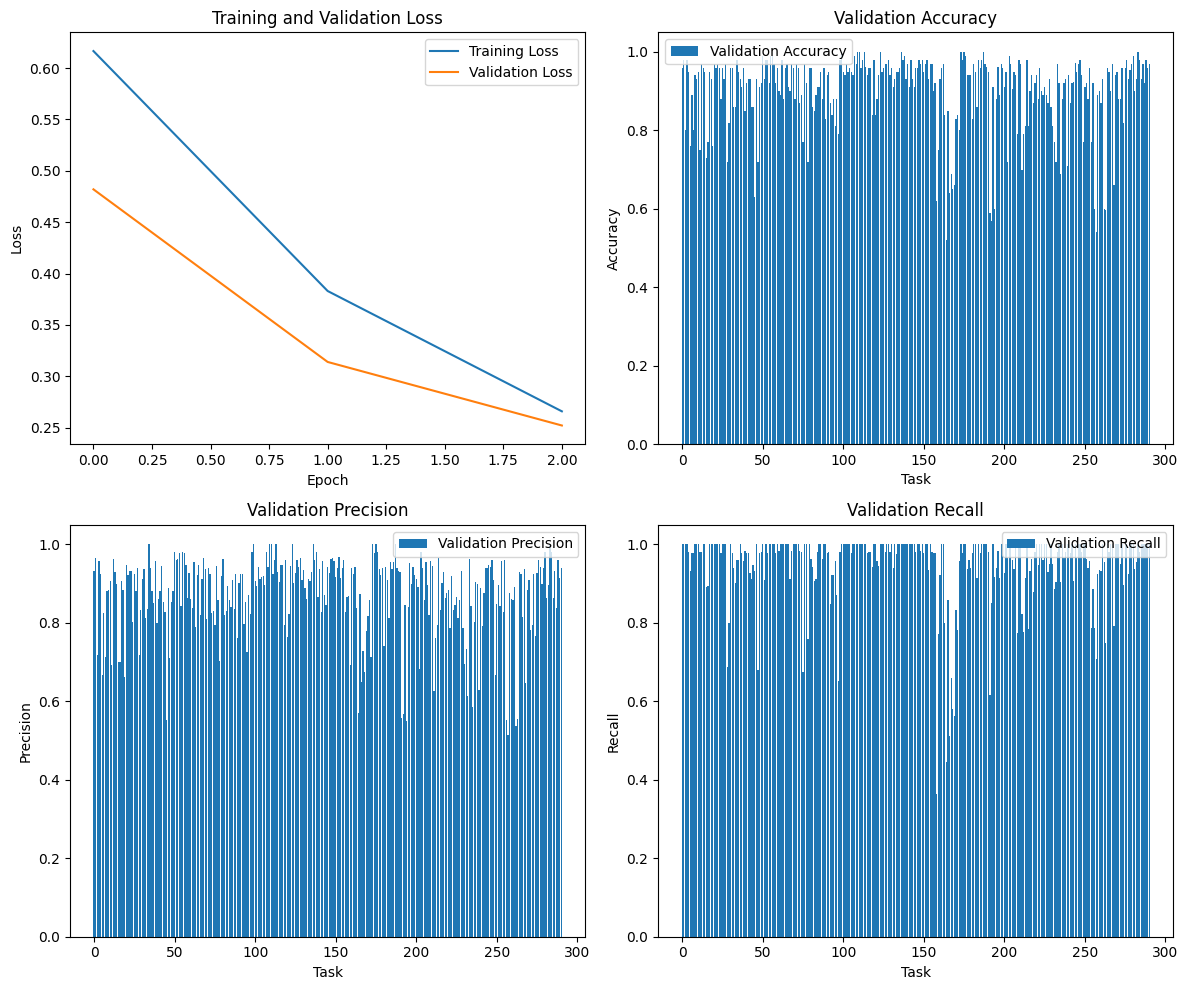

Level B1


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 50/51 [18:37<00:22, 22.34s/it]


Training loss: 0.6357867387858545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [01:44<00:00,  3.23it/s]


Validation loss: 0.5148846247201617
Mean Accuracy: 0.7558632924123451


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 50/51 [18:37<00:22, 22.36s/it]


Training loss: 0.4207582006106407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [01:44<00:00,  3.22it/s]


Validation loss: 0.3536219540881156
Mean Accuracy: 0.8496381419262725


  8%|██████████▌                                                                                                                           | 4/51 [01:29<17:30, 22.35s/it]

In [ ]:
for level in ["A1", "A2", "B1", "B2", "C1", "C2"]:
    train_level_model(level)

## Analyze Cross Validation results

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np

In [2]:
results_df = pd.read_json('../dat/cv_results.json')
print(len(results_df))

30


In [3]:
def mean_of_array(arr):
    return np.mean(np.vstack(arr), axis=0)

def len_of_array(arr):
    return len(arr.iloc[0])

def ratio_above_90(arr):
    return np.mean(np.mean(np.vstack(arr)>0.9, axis=1))

def to_percent(y, position):
    return f"{100 * y:.0f}%"

In [4]:
def get_grand_mean(metric='val_accuracies'):
    grouped_df = results_df[['level', metric]].groupby('level').agg({metric: mean_of_array})
    all_accs = np.concatenate(list(grouped_df[metric]))
    return all_accs.mean()

In [10]:
print(get_grand_mean('val_accuracies'))
print(get_grand_mean('val_recalls'))
print(get_grand_mean('val_precisions'))

0.9506497545008183
0.9731525076930769
0.9339745317999018


In [5]:
plt.rcParams.update({'font.size': 18, 'axes.titlesize': 18, 'xtick.labelsize':14, 'ytick.labelsize':14}) 

{'A1': 0.7467889908256881, 'A2': 0.8378006872852234, 'B1': 0.842603550295858, 'B2': 0.8765432098765432, 'C1': 0.8790697674418604, 'C2': 0.9321428571428572}


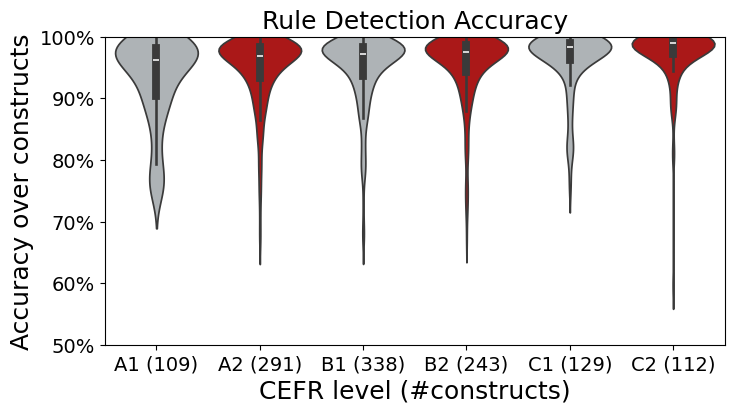

{'A1': 0.9100917431192661, 'A2': 0.9257731958762886, 'B1': 0.9130177514792898, 'B2': 0.9390946502057613, 'C1': 0.9426356589147288, 'C2': 0.9553571428571429}


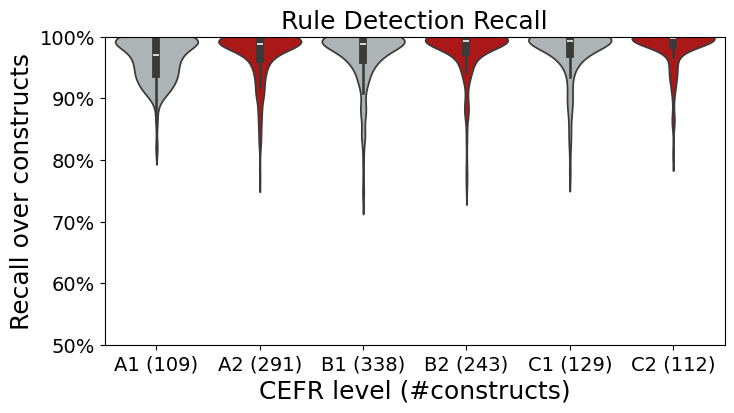

{'A1': 0.673394495412844, 'A2': 0.7615120274914089, 'B1': 0.7781065088757396, 'B2': 0.7868312757201645, 'C1': 0.8449612403100776, 'C2': 0.9196428571428571}


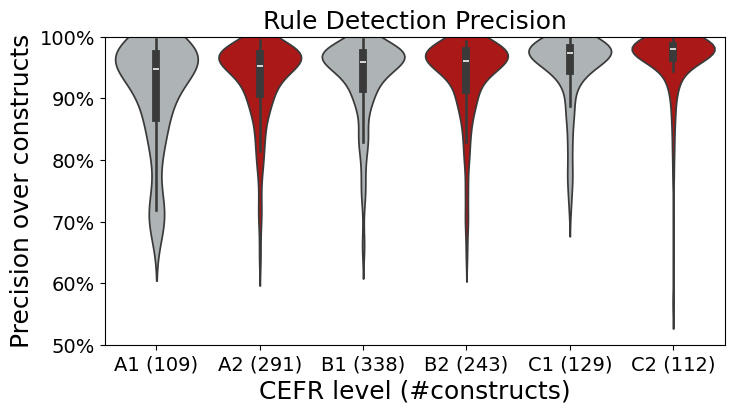

In [11]:
def plot_metric(metric='val_accuracies', label='Accuracy'):
    grouped_df = results_df[['level', metric]].groupby('level').agg({metric: [mean_of_array, len_of_array, ratio_above_90]})
    lengths = grouped_df.to_dict()[(metric, 'len_of_array')]
    print(grouped_df.to_dict()[(metric, 'ratio_above_90')])
    data = grouped_df.to_dict()[(metric, 'mean_of_array')]
    data_with_len = {f'{key} ({lengths[key]})': value for key, value in data.items()}
    maxsize = max([a.size for a in data.values()])
    data_pad = {k:np.pad(v, pad_width=(0, maxsize-v.size,), mode='constant', constant_values=np.nan) for k,v in data_with_len.items()}
    df = pd.DataFrame(data_pad)

    palette = ["#ADB3B7", "#C20000"] * 3

    plt.figure(figsize=(8, 4))
    sns.violinplot(df, palette=palette)
    plt.title(f'Rule Detection {label}')
    plt.xlabel('CEFR level (#constructs)')
    plt.ylabel(f'{label} over constructs')
    plt.ylim(0.5, 1)
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    plt.savefig(f'../doc/classification_{label.lower()}.pdf', bbox_inches='tight')
    plt.show()

plot_metric('val_accuracies', 'Accuracy')
plot_metric('val_recalls', 'Recall')
plot_metric('val_precisions', 'Precision')